<a href="https://colab.research.google.com/github/quynhu-d/kws/blob/main/KWS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and misc

In [ ]:
!git clone https://github.com/quynhu-d/kws

Cloning into 'kws'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 35 (delta 8), reused 9 (delta 2), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [1]:
!pip install torchaudio==0.9.1
!pip install thop

     |████████████████████████████████| 1.9 MB 5.3 MB/s 
     |████████████████████████████████| 831.4 MB 4.2 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.


In [2]:
from thop import profile
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

In [3]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

history = defaultdict(list)

In [4]:
import torch
import random
import numpy as np

torch.manual_seed(47)
random.seed(47)
np.random.seed(47)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [6]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

### SpeechCommandDataset

In [7]:
#!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
#!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log
!mkdir speech_commands && tar -C speech_commands -xvzf /content/drive/MyDrive/Colab\ Notebooks/DLA/KWS/speech_commands_v0.01.tar.gz 1> log

In [8]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [ ]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [ ]:
dataset.csv.sample(5)

,path,keyword,label
50905,speech_commands/no/8523766b_nohash_1.wav,no,0
9698,speech_commands/zero/7b301939_nohash_1.wav,zero,0
1693,speech_commands/on/29fb33da_nohash_2.wav,on,0
6840,speech_commands/four/b1f8326d_nohash_0.wav,four,0
19276,speech_commands/yes/3ae5c04f_nohash_1.wav,yes,0


### Augmentations

In [9]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [ ]:
# indexes = torch.randperm(len(dataset))
# train_indexes = indexes[:int(len(dataset) * 0.8)]
# val_indexes = indexes[int(len(dataset) * 0.8):]

# train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
# val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [10]:
# train_df.to_csv('train_df.csv')
# val_df.to_csv('val_df.csv')

# saved train_val split
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/train_df.csv')
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/val_df.csv')

In [13]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [14]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weight = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [15]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [22]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [23]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [11]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [12]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

In [ ]:
# melspec_train(next(iter(train_loader))[0].to('cuda')).shape

torch.Size([128, 40, 101])

### Quality measurement functions:

In [24]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [25]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [26]:
class Attention(nn.Module):

    def __init__(self, input_size: int, hidden_size=None):
        super().__init__()
        if hidden_size is None:
            hidden_size = input_size
        self.energy = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig, attention_hidden_sz=None):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )
        
        self.attention = Attention(config.hidden_size, attention_hidden_sz)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [27]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

# Utils

In [28]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

In [ ]:
# def get_size_in_megabytes(model):
#     num_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
#     param_size = next(model.parameters()).element_size()
#     return (num_params * param_size) / (2 ** 20)

# get_size_in_megabytes(model)

In [29]:
import os
# count size of model with its file
# from https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html
def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (KB):', size/1024)
    os.remove('temp.p')
    return size

In [30]:
def config_to_dict(config, hparam_n = 15):
    return {key: config.__dict__[key] for key in sorted(config.__dict__.keys())[-hparam_n:]}
config_to_dict(config)

{'batch_size': 128,
 'bidirectional': False,
 'cnn_out_channels': 8,
 'device': device(type='cuda', index=0),
 'gru_num_layers': 2,
 'hidden_size': 64,
 'kernel_size': (5, 20),
 'keyword': 'sheila',
 'learning_rate': 0.0003,
 'n_mels': 40,
 'num_classes': 2,
 'num_epochs': 20,
 'sample_rate': 16000,
 'stride': (2, 8),
 'weight_decay': 1e-05}

# Base Model Training

In [ ]:
config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

In [ ]:
# TRAIN UNTIL 5e-5 is reached

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)
    if au_fa_fr <= 5e-5:
        break

In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/DLA/KWS/models/base_model.pt')
# np.save('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/base_hist.npy', history['val_metric'])

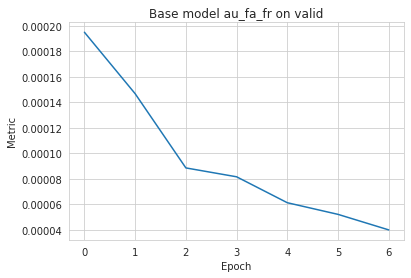

In [6]:
base_hist = np.load('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/base_hist.npy')
plt.plot(base_hist)
plt.title('Base model au_fa_fr on valid')
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.show()

In [ ]:
base_mb_sz = print_size_of_model(model, ' Base Model') / (2**20)
base_macs, base_n_params = profile(model, (torch.randn(1,40,101),))
base_score = validation(
    base_model, val_loader, melspec_val, config.device
)

In [ ]:
table_ = pd.DataFrame()
table_= table_.append(
    {
        **{
            'SETTING': 'Base_5e-5',
            'MACS': base_macs, 'MB_SZ': base_mb_sz, 'N_PARAMS': base_n_params, 
            'METRIC': base_score
        },
        **config_to_dict(base_config) 
    },
    ignore_index=True
)
# table_.to_csv('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/kws_experiments.csv', index=False)

# Streaming

Реализация пофреймового стриминга для обученной модели.

In [310]:
class StreamingCRNN(CRNN):
    def __init__(self, config, max_window_length, state_dict_path=None):
        self.max_window_length = max_window_length
        super().__init__(config)
        if state_dict_path:
            self.load_state_dict(torch.load(state_dict_path, map_location=config.device), strict=False)
            print('Model loaded from %s' % state_dict_path)
        self.gru_buffer = None
        self.gru_hidden = None
        self.step = config.stride[1]
        self.frame_sz = config.kernel_size[1]

    def reset(self):
        self.gru_hidden = None
        self.gru_buffer = None    

    def forward(self, frame):
        self.eval()
        frame = frame.unsqueeze(dim=1)
        if frame.shape[-1] < self.frame_sz:
            return
        conv_output = self.conv(frame).transpose(-1,-2)
        gru_output, hidden = self.gru(conv_output, self.gru_hidden)
        self.gru_hidden = hidden
        if self.gru_buffer is None:
            self.gru_buffer = gru_output
        else:
            self.gru_buffer = torch.cat([self.gru_buffer, gru_output], dim=1)
        if self.gru_buffer.shape[1] > self.max_window_length:
            self.gru_buffer = self.gru_buffer[:,1:]
        contex_vector = self.attention(self.gru_buffer)
        output = self.classifier(contex_vector)
        return output

In [318]:
# glue n_samples audio tracks (with keyword uttered once)
subset_idx = None
n_samples = 10
while True:
    subset = val_df.sample(n_samples)
    if (subset.label == 1).sum() == 1:
        subset_idx = subset.index
        break
wavs, labels = Collator()([val_set[idx] for idx in subset_idx])
spec = torch.flatten(melspec_val(wavs).transpose(-1,-2),start_dim=0,end_dim=1).transpose(-1,-2)
idx_1 = torch.where(labels == 1)[0].flatten().item()
# plt.figure(figsize=(20,5))
# plt.imshow(spec)
print(labels)

tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])


In [319]:
from collections import defaultdict
probs = defaultdict(list)
for max_window_length in range(2, 13, 2):
    streaming_base_model = StreamingCRNN(
        base_config, max_window_length=max_window_length, 
        state_dict_path='/content/drive/MyDrive/Colab Notebooks/DLA/KWS/models/base_model.pt'
    )
    frame_sz = base_config.kernel_size[1]
    step = base_config.stride[1]
    probs[max_window_length] = []
    for i in range(0,spec.shape[1], step):    # move frame by frame
        frame = spec[:,i:i+frame_sz].unsqueeze(0)
        if frame.shape[-1] < streaming_base_model.frame_sz:
            continue
        output = streaming_base_model(frame)
        frame_prob = F.softmax(output, dim=-1).squeeze(0)[1].item()
        probs[max_window_length].append(frame_prob)
        assert len(streaming_base_model.gru_buffer) <= max_window_length

Model loaded from /content/drive/MyDrive/Colab Notebooks/DLA/KWS/models/base_model.pt
Model loaded from /content/drive/MyDrive/Colab Notebooks/DLA/KWS/models/base_model.pt
Model loaded from /content/drive/MyDrive/Colab Notebooks/DLA/KWS/models/base_model.pt
Model loaded from /content/drive/MyDrive/Colab Notebooks/DLA/KWS/models/base_model.pt
Model loaded from /content/drive/MyDrive/Colab Notebooks/DLA/KWS/models/base_model.pt
Model loaded from /content/drive/MyDrive/Colab Notebooks/DLA/KWS/models/base_model.pt


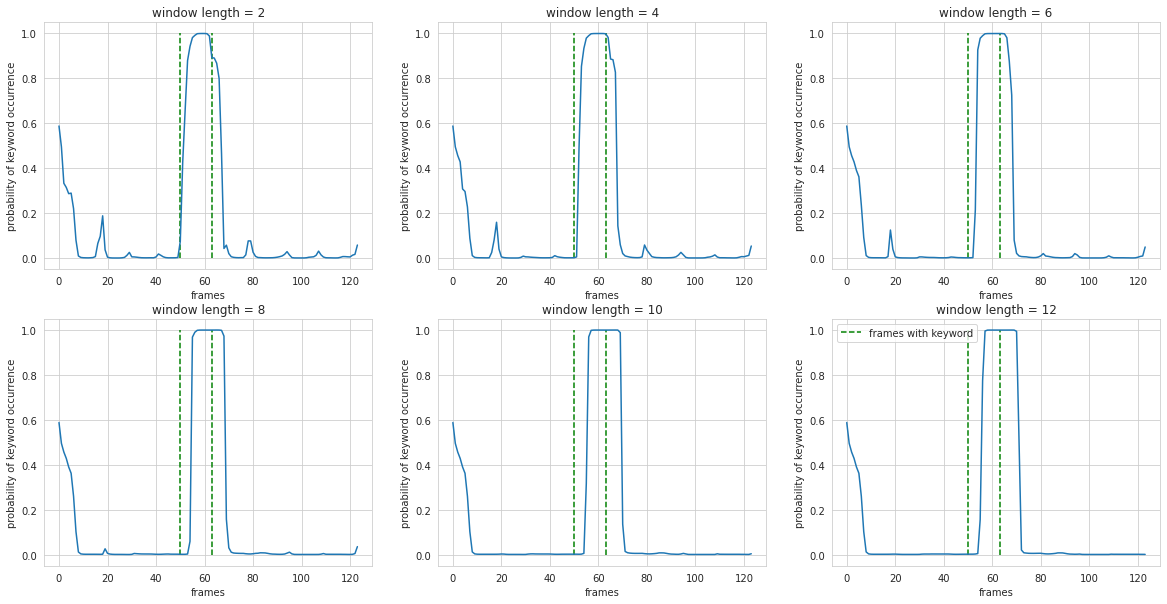

In [320]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
fig, axs = plt.subplots(2,3, figsize=(20,10))
x_min = idx_1 * (spec.shape[1] // len(labels)) // step
x_max = (idx_1 + 1) * (spec.shape[1] // len(labels)) // step
for ax, window_length in zip(axs.reshape(-1), range(2,13,2)):
    ax.plot(probs[window_length])
    ax.vlines([x_min,x_max],ymin=0,ymax=1, color='green', linestyle='dashed', label='frames with keyword')
    ax.set(xlabel='frames', ylabel='probability of keyword occurrence')
    ax.set_title('window length = %d' % window_length)
plt.legend()
plt.show()

# Model Compression Experiments

## Setting 1. Dynamic Quantization

Пробуем динамическую квантизацию базовой модели. MACS здесь будут посчитаны неверно, но это потом учтём.

In [ ]:
base_config = TaskConfig()
base_config.hidden_size = 64
base_config.cnn_out_channels = 8
base_model = CRNN(base_config)
base_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/models/base_model.pt', map_location=config.device), strict=False)
dq_int8_model = torch.quantization.quantize_dynamic(
    base_model, {nn.GRU, nn.Linear}, dtype=torch.qint8
)

In [ ]:
dq_int8_mb_sz = print_size_of_model(dq_int8_model, 'Dynamic Quantization, int8') / (2**20)
dq_int8_macs, dq_int8_n_params = profile(dq_int8_model, (torch.randn(1,40,101),))
dq_int8_score = validation(
    dq_int8_model, val_loader, melspec_val, config.device
)

model:  Dynamic Quantization, int8  	 Size (KB): 80.5966796875
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] 

102it [00:17,  5.84it/s]


In [ ]:
table_ = pd.DataFrame(columns=table.columns)
table_= table_.append(
    {
        **{
            'SETTING': 'dqint8',
            'MACS': dq_int8_macs, 'MB_SZ': dq_int8_mb_sz, 'N_PARAMS': dq_int8_n_params, 
            'METRIC': dq_int8_score
        },
        **config_to_dict(base_config) 
    },
    ignore_index=True
)
table_.to_csv('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/kws_experiments.csv', mode='a', header=False, index=False)

## Setting 2. Dark Knowledge Distillation

Будем с помощью базовой модели обучать модели поменьше. Посмотрим на модели-студенты с разными значения `hidden_size` и `cnn_out_channels`.

В `DKD Training Logs` нарисованы графики обучения для всех моделей-студентов. Модели-студенты обучались до достижения результата, не меньшего 5е-5 * 1.1.

In [69]:
def train_epoch_w_teacher(student, teacher, opt, loader, log_melspec, device, temp=20, alpha=.5):
    """
        student: model to train
        teacher: model to distill from
        opt: optimizer
        loader: train dataloader
        log_melspec: train MelSpec
        device: cuda or cpu
        temp: temperature of distillation
        alpha: coefficient of student loss in total loss (coefficient of distillation loss is 1 - alpha)
    """
    student.train()
    teacher.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)
        opt.zero_grad()

        teacher_logits = teacher(batch).detach()
        student_logits = student(batch)

        soft_labels = F.softmax(teacher_logits / temp, dim=-1)
        soft_preds = F.softmax(student_logits / temp, dim=-1)
        distill_loss = F.kl_div(soft_preds.log(), soft_labels, reduction='sum')    # KL divergence

        hard_probs = F.softmax(student_logits, dim=-1)
        student_loss = F.cross_entropy(student_logits, labels)

        loss = alpha * student_loss + (1 - alpha) * distill_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(hard_probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

def train_w_teacher(
    student, teacher, config, opt, loaders, log_melspec, 
    temp=20, alpha=.5, 
    model_path=None, history=None, history_path=None
    ):
    """
        student: model to train
        teacher: model to distill from
        config: (TaskConfig)
        opt: optimizer
        loaders: tuple of train and val dataloaders
        log_melspec: tuple of train and val MelSpec

        temp: temperature of distillation
        alpha: coefficient of student loss in total loss (coefficient of distillation loss is 1 - alpha)
        
        model_path: if not None, model is saved there
        history: dictionary containing training loggings
        history_path: path to save history at
    """
    train_loader, val_loader = loaders
    melspec_train, melspec_val = log_melspec
    if history is None:
        history = defaultdict(list)
    for n in range(config.num_epochs):

        train_epoch_w_teacher(
            student, teacher, opt, train_loader, melspec_train, config.device, temp, alpha
        )
        if model_path:
            torch.save(student.state_dict(), model_path)
        au_fa_fr = validation(student, val_loader, melspec_val, config.device)
        history['val_metric'].append(au_fa_fr)
        if history_path:
            np.save(history_path, history['val_metric'])

        clear_output()
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.show()

        print('END OF EPOCH %d / %d' % (n, config.num_epochs))
        
        if au_fa_fr <= 1.1 * 5e-5:
            break
    return history

In [49]:
model = CRNN(config)    # base model -- teacher
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/models/base_model.pt', map_location=config.device), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['total_ops', 'total_params', 'conv.total_ops', 'conv.total_params', 'conv.1.total_ops', 'conv.1.total_params', 'attention.total_ops', 'attention.total_params', 'attention.energy.total_ops', 'attention.energy.total_params', 'attention.energy.1.total_ops', 'attention.energy.1.total_params'])

### Previous Runs

Для нескольких наборов параметров изначально модели были отдельно обучены, в части `Other Parameters` уже всё собрано вместе и запущено для всех остальных значений.

#### 1. hidden=16, cnn_out=4

In [ ]:
student_config = TaskConfig()
student_config.hidden_size = 16
student_config.cnn_out_channels = 4
student_config.num_epochs = 50

student_model = CRNN(student_config).to(student_config.device)
student_opt = torch.optim.Adam(
    student_model.parameters(),
    lr=student_config.learning_rate,
    weight_decay=student_config.weight_decay
)
print('Number of params %d' % count_parameters(student_model))
student_model

Number of params 6679


CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(72, 16, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=16, out_features=2, bias=True)
)

In [ ]:
res_distill = train_w_teacher(student_model, model, student_config, student_opt, 
                (train_loader, val_loader), (melspec_train, melspec_val), history=res_distill)

In [ ]:
torch.save(student_model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/DLA/KWS/student_models/student_model_16_4.pt')
np.save('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/dkd_hist_16_4.npy', res_distill['val_metric'])

In [ ]:
student_mb_sz = print_size_of_model(student_model, 'Distilled, cnn_out=4, hidden_sz=16') / (2 ** (20))

model:  Distilled, cnn_out=4, hidden_sz=16  	 Size (KB): 30.4892578125


In [ ]:
student_macs, student_n_params = profile(CRNN(student_config), (torch.randn(1, 40, 101),))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


In [ ]:
table_ = pd.DataFrame(columns=table.columns)
table_= table_.append(
    {
        **{
            'SETTING': 'DKD_16_4',
            'MACS': student_macs, 'MB_SZ': student_mb_sz, 'N_PARAMS': student_n_params, 
            'METRIC': res_distill['val_metric'][-1]
        },
        **config_to_dict(student_config) 
    },
    ignore_index=True
)
table_.to_csv('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/kws_experiments.csv', mode='a', header=False, index=False)

#### 2. hidden=16, cnn_out = 8

In [ ]:
student_config_16_8 = TaskConfig()
student_config_16_8.hidden_size = 16
student_config_16_8.cnn_out_channels = 8
student_config_16_8.num_epochs = 50

student_model_16_8 = CRNN(student_config_16_8).to(student_config_16_8.device)
student_opt_16_8 = torch.optim.Adam(
    student_model_16_8.parameters(),
    lr=student_config.learning_rate,
    weight_decay=student_config.weight_decay
)
print('Number of params %d' % count_parameters(student_model_16_8))
student_model_16_8

Number of params 10539


CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 16, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=16, out_features=2, bias=True)
)

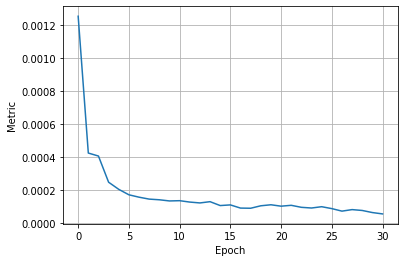

END OF EPOCH 30 / 50


In [ ]:
res_distill_16_8 = train_w_teacher(student_model_16_8, model, student_config_16_8, student_opt_16_8, 
                (train_loader, val_loader), (melspec_train, melspec_val))

In [ ]:
torch.save(student_model_16_8.state_dict(), '/content/drive/MyDrive/Colab Notebooks/DLA/KWS/student_models/student_model_16_8.pt')
np.save('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/dkd_hist_16_8', res_distill_16_8)

In [ ]:
student_16_8_mb_sz = print_size_of_model(student_model_16_8, 'Distilled, cnn_out=8, hidden_sz=16') / (2 ** (20))

model:  Distilled, cnn_out=8, hidden_sz=16  	 Size (KB): 45.5517578125


In [ ]:
student_16_8_macs, student_16_8_n_params = profile(CRNN(student_config_16_8), (torch.randn(1, 40, 101),))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


In [ ]:
table_ = pd.DataFrame(columns=table.columns)
table_= table_.append(
    {
        **{
            'SETTING': 'DKD_16_8',
            'MACS': student_16_8_macs, 'MB_SZ': student_16_8_mb_sz, 'N_PARAMS': student_16_8_n_params, 
            'METRIC': res_distill_16_8['val_metric'][-1]
        },
        **config_to_dict(student_config_16_8) 
    },
    ignore_index=True
)
table_.to_csv('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/kws_experiments.csv', mode='a', header=False, index=False)

#### 3. hidden=32, out=8

In [ ]:
student_config_32_8 = TaskConfig()
student_config_32_8.hidden_size = 32
student_config_32_8.cnn_out_channels = 8
student_config_32_8.num_epochs = 50

student_model_32_8 = CRNN(student_config_32_8).to(student_config_32_8.device)
student_opt_32_8 = torch.optim.Adam(
    student_model_32_8.parameters(),
    lr=student_config.learning_rate,
    weight_decay=student_config.weight_decay
)
print('Number of params %d' % count_parameters(student_model_32_8))
student_model_32_8

Number of params 25387


CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)

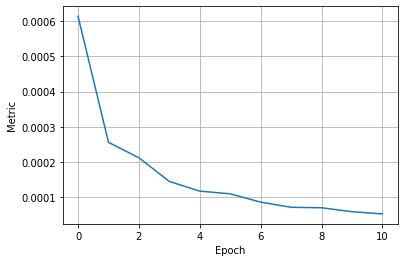

END OF EPOCH 10 / 50


In [ ]:
res_distill_32_8 = train_w_teacher(student_model_32_8, model, student_config_32_8, student_opt_32_8, 
                (train_loader, val_loader), (melspec_train, melspec_val))

In [ ]:
torch.save(student_model_32_8.state_dict(), '/content/drive/MyDrive/Colab Notebooks/DLA/KWS/student_models/student_model_32_8.pt')
np.save('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/dkd_history_32_8.npy', res_distill_32_8)

In [ ]:
student_32_8_mb_sz = print_size_of_model(student_model_32_8, 'Distilled, cnn_out=8, hidden_sz=32') / (2 ** (20))
student_32_8_macs, student_32_8_n_params = profile(CRNN(student_config_32_8), (torch.randn(1, 40, 101),))

model:  Distilled, cnn_out=8, hidden_sz=32  	 Size (KB): 103.5517578125
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


In [ ]:
table_ = pd.DataFrame(columns=table.columns)
table_= table_.append(
    {
        **{
            'SETTING': 'DKD_32_8',
            'MACS': student_32_8_macs, 'MB_SZ': student_32_8_mb_sz, 'N_PARAMS': student_32_8_n_params, 
            'METRIC': res_distill_32_8['val_metric'][-1]
        },
        **config_to_dict(student_config_32_8) 
    },
    ignore_index=True
)
table_.to_csv('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/kws_experiments.csv', mode='a', header=False, index=False)

#### 4. hidden=32, out=4

In [ ]:
student_config_32_4 = TaskConfig()
student_config_32_4.hidden_size = 32
student_config_32_4.cnn_out_channels = 4
student_config_32_4.num_epochs = 50

student_model_32_4 = CRNN(student_config_32_4).to(student_config_32_4.device)
student_opt_32_4 = torch.optim.Adam(
    student_model_32_4.parameters(),
    lr=student_config.learning_rate,
    weight_decay=student_config.weight_decay
)
print('Number of params %d' % count_parameters(student_model_32_4))
student_model_32_4

Number of params 18071


CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(72, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)

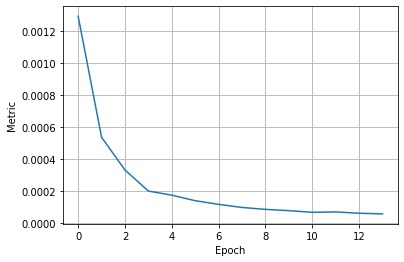

END OF EPOCH 13 / 50


In [ ]:
res_distill_32_4 = train_w_teacher(student_model_32_4, model, student_config_32_4, student_opt_32_4, 
                (train_loader, val_loader), (melspec_train, melspec_val))

In [ ]:
torch.save(student_model_32_4.state_dict(), '/content/drive/MyDrive/Colab Notebooks/DLA/KWS/student_models/student_model_32_4.pt')
np.save('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/dkd_history_32_4.npy', res_distill_32_4)

In [ ]:
student_32_4_mb_sz = print_size_of_model(student_model_32_4, 'Distilled, cnn_out=4, hidden_sz=32') / (2 ** (20))
student_32_4_macs, student_32_4_n_params = profile(CRNN(student_config_32_4), (torch.randn(1, 40, 101),))

model:  Distilled, cnn_out=4, hidden_sz=32  	 Size (KB): 74.9892578125
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


In [ ]:
table_ = pd.DataFrame(columns=table.columns)
table_= table_.append(
    {
        **{
            'SETTING': 'DKD_32_4',
            'MACS': student_32_4_macs, 'MB_SZ': student_32_4_mb_sz, 'N_PARAMS': student_32_4_n_params, 
            'METRIC': res_distill_32_4['val_metric'][-1]
        },
        **config_to_dict(student_config_32_4) 
    },
    ignore_index=True
)
table_.to_csv('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/kws_experiments.csv', mode='a', header=False, index=False)

In [ ]:
# Previous experiments results savings
# np.save('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/dkd_hist_%d_%d.npy' % (16, 4), res_distill['val_metric'])
# np.save('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/dkd_hist_%d_%d.npy' % (16, 8), res_distill_16_8['val_metric'])
# np.save('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/dkd_hist_%d_%d.npy' % (32, 4), res_distill_32_4['val_metric'])
# np.save('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/dkd_hist_%d_%d.npy' % (32, 8), res_distill_32_8['val_metric'])

### Other Parameters

In [52]:
# function to train student model + results logging
def dkdistill(
    teacher, student, opt, config, loaders, log_melspecs, 
    val_hist_path=None, model_path=None, table_path=None
    ):
    """
        teacher: model to distill from
        student: model to train
        opt: optimizer
        config: (TaskConfig)
        loaders: tuple of train and val dataloaders
        log_melspec: tuple of train and val MelSpec

        temp: temperature of distillation
        alpha: coefficient of student loss in total loss (coefficient of distillation loss is 1 - alpha)
        
        model_path: if not None, model is saved there
        val_hist_path: path to save validation loggings at
        table_path: experiments results csv file path to append results to
    """    
    hist = train_w_teacher(student, teacher, config, opt, loaders, log_melspecs, model_path=model_path, history_path=val_hist_path)
    if val_hist_path:
        np.save(val_hist_path, hist['val_metric'])
    if model_path:
        torch.save(student.state_dict(), model_path)    
    student_mb_sz = print_size_of_model(student, 'Distilled model') / (2 ** (20))
    student_macs, student_n_params = profile(CRNN(config), (torch.randn(1, 40, 101),))
    table_ = pd.DataFrame(
        columns=[
            'SETTING', 'MACS', 'MB_SZ', 'N_PARAMS', 'METRIC', 'batch_size',
            'bidirectional', 'cnn_out_channels', 'device', 'gru_num_layers',
            'hidden_size', 'kernel_size', 'keyword', 'learning_rate', 'n_mels',
            'num_classes', 'num_epochs', 'sample_rate', 'stride', 'weight_decay'
        ]
    )
    table_= table_.append(
        {
            **{
                'SETTING': 'DKD_%d_%d' % (config.hidden_size, config.cnn_out_channels),
                'MACS': student_macs, 'MB_SZ': student_mb_sz, 'N_PARAMS': student_n_params, 
                'METRIC': hist['val_metric'][-1]
            },
            **config_to_dict(config) 
        },
        ignore_index=True
    )
    if table_path:
        table_.to_csv(table_path, mode='a', header=False, index=False)
    return hist, table_

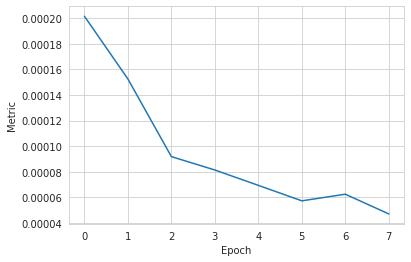

END OF EPOCH 7 / 50
model:  Distilled model  	 Size (KB): 222.9482421875
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


In [ ]:
# run experiments with models of various hidden_size and cnn_out_channels parameters
from itertools import product
results = []
for (h,c) in product([8,16,32,64], [4,8,16]):
    # if ((h,c) == (32,8)) or ((h,c)==(32,4)) or ((h,c)==(16,4)) or ((h,c)==(16,8)) or ((h,c)==(8,4)):
    # experiments run before (see Previous Runs)
    #     continue
    student_config = TaskConfig()
    student_config.hidden_size = h
    student_config.cnn_out_channels = c
    student_config.num_epochs = 50

    student_model = CRNN(student_config).to(student_config.device)
    if count_parameters(model) <= count_parameters(student_model):
    # train only models smaller than the teacher model
        continue
    student_opt = torch.optim.Adam(
        student_model.parameters(),
        lr=student_config.learning_rate,
        weight_decay=student_config.weight_decay
    )
    print('Number of params %d' % count_parameters(student_model))
    print(student_model)
    res = dkdistill(
        model, student_model, student_opt, student_config, 
        (train_loader, val_loader), (melspec_train, melspec_val),
        val_hist_path='/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/dkd_hist_%d_%d.npy' % (h, c),
        model_path='/content/drive/MyDrive/Colab Notebooks/DLA/KWS/student_models/student_model_%d_%d.pt' % (h, c),
        table_path='/content/drive/MyDrive/Colab Notebooks/DLA/KWS/kws_experiments.csv')
    results.append(res)

### DKD Training Logs

Здесь разными способами нарисованные графики обучения при разных параметрах. 

Видно, что с увеличением `hidden_size` нужное качество достигается быстрее (при `hidden_size` = 8 за 50 эпох качество в 5.5е-5 не достигалось). Также понятно, что чем ближе модель-студент к модели-учителю (`hidden_size` = 64, `cnn_out_channels` = 8), тем лучше получалось качество.

In [17]:
import numpy as np
from itertools import product
results = {}
for (h,c) in product([8,16,32,64], [4,8,16]):
    try:
        arr = np.load('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/dkd_hist_%d_%d.npy' % (h, c))
        results[(h, c)] = arr
    except:
        continue

In [18]:
base_hist = np.load('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/base_hist.npy')

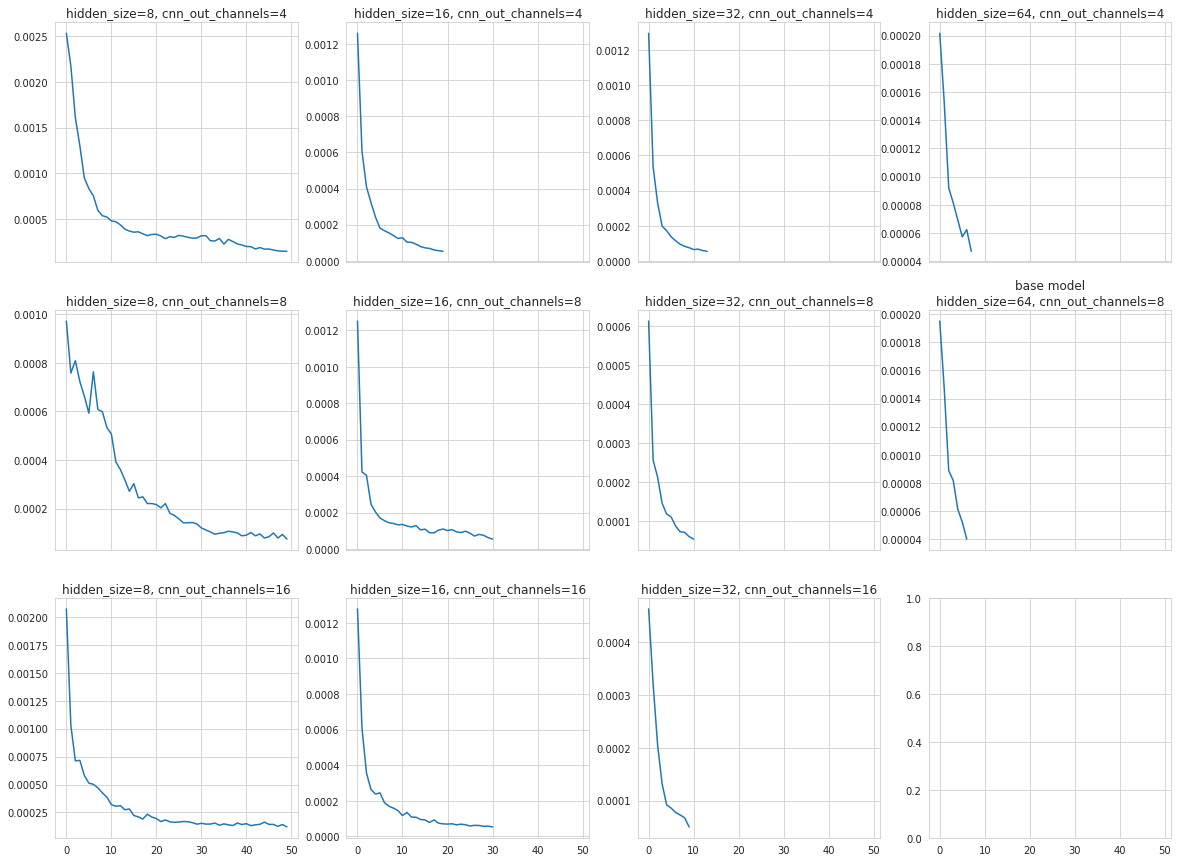

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
fig, axs = plt.subplots(3, 4, figsize=(20, 15), sharex=True)
for (c,h), ax in zip(product([4,8,16], [8,16,32,64]), axs.reshape(-1)):
    if (h == 64) and ((c == 8) or (c == 16)): continue
    arr = results[(h, c)]
    sns.lineplot(x=range(len(arr)), y=arr, ax=ax)
    ax.set_title('hidden_size=%d, cnn_out_channels=%d' % (h, c))
axs[1][-1].set_title('base model\nhidden_size=%d, cnn_out_channels=%d' % (64, 8))
sns.lineplot(x=range(len(base_hist)),y=base_hist,ax=axs[1][-1])
plt.show()

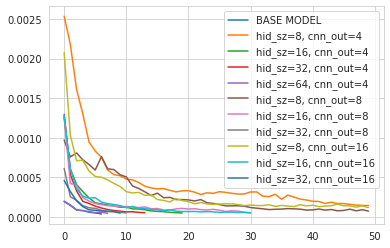

In [ ]:
sns.lineplot(x=range(len(base_hist)),y=base_hist,label='BASE MODEL')
for (c,h)in product([4,8,16], [8,16,32,64]):
    if (h == 64) and ((c == 8) or (c == 16)): continue
    arr = results[(h, c)]
    sns.lineplot(x=range(len(arr)), y=arr, label='hid_sz=%d, cnn_out=%d' % (h, c), markers='--')
plt.legend()
plt.show()

*plotly поудобнее будет, правда вывод вот не сохраняется (но запустить, в принципе, можно)*

In [20]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(base_hist)), y=base_hist,
                    mode='lines', line=dict(color='black'),
                    name='BASE MODEL'))
for (h, c)in product([8,16,32,64], [4,8,16]):
    if (h == 64) and ((c == 8) or (c == 16)): continue
    arr = results[(h, c)]

    fig.add_trace(
        go.Scatter(
            x=np.arange(len(arr)), y=arr,
            mode='lines', line=dict(dash='dash'),
            name='hid_sz=%d, cnn_out=%d' % (h, c)
        )
    )

fig.update_layout(title='AU_FA_FR on validation',
                   xaxis_title='epochs',
                   yaxis_title='AU_FA_FR')

fig.show()

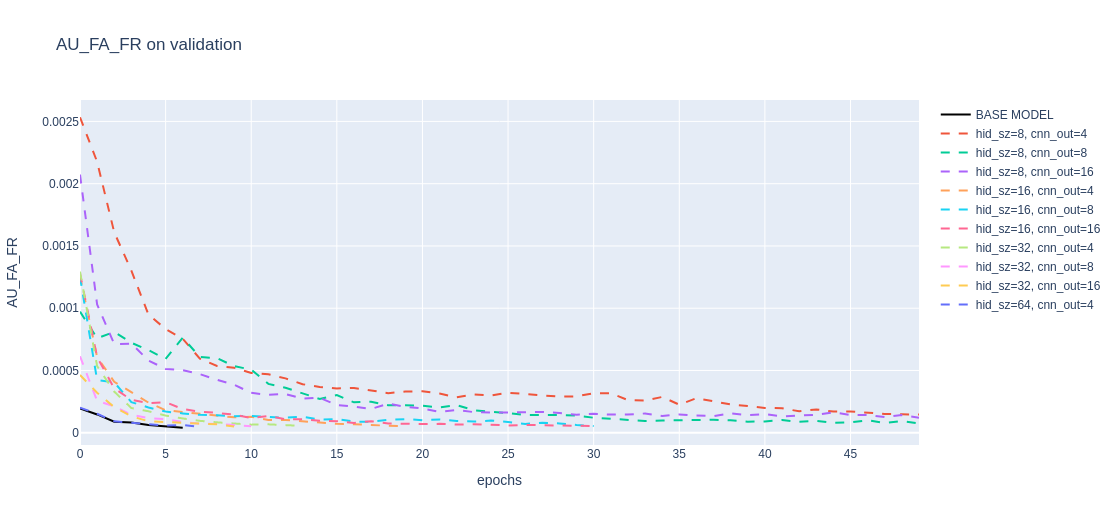

## Setting 2.1 DQINT8 + Dark Knowledge Distillation

Берём лучшую модель из Dark Knowledge Distillation (`hidden_size` = 16, `cnn_out_channels` = 4) и квантизируем её.

In [ ]:
dkd_16_4_config = TaskConfig()
dkd_16_4_config.hidden_size = 16
dkd_16_4_config.cnn_out_channels = 4
dkd_16_4_model = CRNN(dkd_16_4_config)
dkd_16_4_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/student_models/student_model_16_4.pt', map_location=config.device))
dq_int8_dkd_16_4_model = torch.quantization.quantize_dynamic(
    dkd_16_4_model, {nn.GRU, nn.Linear}, dtype=torch.qint8
)

In [ ]:
dq_int8_dkd_16_4_mb_sz = print_size_of_model(dq_int8_dkd_16_4_model, 'Dynamic Quantization, int8') / (2**20)
dq_int8_dkd_16_4_macs, dq_int8_dkd_16_4_n_params = profile(dq_int8_dkd_16_4_model, (torch.randn(1,40,101),))
dq_int8_dkd_16_4_score = validation(
    dq_int8_dkd_16_4_model, val_loader, melspec_val, config.device
)

model:  Dynamic Quantization, int8  	 Size (KB): 15.2841796875
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] 

In [ ]:
table_ = pd.DataFrame(columns=table.columns)
table_= table_.append(
    {
        **{
            'SETTING': 'DKD_16_4 + dqint8',
            'MACS': dq_int8_dkd_16_4_macs, 'MB_SZ': dq_int8_dkd_16_4_mb_sz, 
            'N_PARAMS': dq_int8_dkd_16_4_n_params, 
            'METRIC': dq_int8_dkd_16_4_score
        },
        **config_to_dict(dkd_16_4_config) 
    },
    ignore_index=True
)
table_.to_csv('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/kws_experiments.csv', mode='a', header=False, index=False)

## Setting 3. Attention Distillation

In [122]:
att_sz = 16
student_config = TaskConfig()
student_config.num_epochs = 50

student_model = CRNN(student_config)
student_model.attention = Attention(student_config.hidden_size, att_sz)    # designing smaller attention module
student_model.to(student_config.device)
student_opt = torch.optim.Adam(
    student_model.parameters(),
    lr=student_config.learning_rate,
    weight_decay=student_config.weight_decay
)
# print('Number of params %d' % count_parameters(student_model))
student_model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [63]:
model.to(student_config.device)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [119]:
# function to train student model + results logging
def kdistill(
    teacher, student, opt, config, loaders, log_melspecs, 
    val_hist_path=None, model_path=None, table_path=None, att_sz=16
    ):
    hist = train_w_teacher(student, teacher, config, opt, loaders, log_melspecs, model_path=model_path, history_path=val_hist_path)
    if val_hist_path:
        np.save(val_hist_path, hist['val_metric'])
    if model_path:
        torch.save(student.state_dict(), model_path)    
    student_mb_sz = print_size_of_model(student, 'Distilled model') / (2 ** (20))
    student_macs, student_n_params = profile(student, (torch.randn(1, 40, 101).to(config.device),))
    table_ = pd.DataFrame(
        columns=[
            'SETTING', 'MACS', 'MB_SZ', 'N_PARAMS', 'METRIC', 'batch_size',
            'bidirectional', 'cnn_out_channels', 'device', 'gru_num_layers',
            'hidden_size', 'attention_size', 'kernel_size', 
            'keyword', 'learning_rate', 'n_mels',
            'num_classes', 'num_epochs', 'sample_rate', 'stride', 'weight_decay'
        ]
    )
    table_= table_.append(
        {
            **{
                'SETTING': 'KD_%d' % (att_sz),
                'MACS': student_macs, 'MB_SZ': student_mb_sz, 'N_PARAMS': student_n_params, 
                'METRIC': hist['val_metric'][-1],
                'attention_size': att_sz
            },
            **config_to_dict(config) 
        },
        ignore_index=True
    )
    if table_path:
        table_.to_csv(table_path, mode='a', header=False, index=False)
    return hist, table_

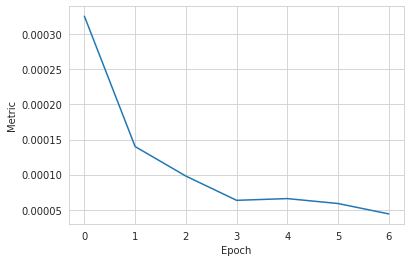

END OF EPOCH 6 / 50
model:  Distilled model  	 Size (KB): 266.1357421875
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


In [123]:
res = kdistill(
    model, student_model, student_opt, student_config, 
    (train_loader, val_loader), (melspec_train, melspec_val),
    val_hist_path='/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/kd_hist_%d.npy' % (att_sz),
    model_path='/content/drive/MyDrive/Colab Notebooks/DLA/KWS/student_models/student_model_kd_%d.pt' % (att_sz),
    att_sz=att_sz)

In [99]:
table_ = res[1]

In [117]:
(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/kws_experiments.csv').append(table_)).to_csv('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/kws_experiments.csv',index=False)

## Setting 3.1 Attention Distillation + Dynamic Quantization

In [31]:
att_sz = 16
student_config = TaskConfig()
student_model = CRNN(student_config)
student_model.attention = Attention(student_config.hidden_size, att_sz)
student_model.to(student_config.device)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [32]:
student_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/student_models/student_model_kd_16.pt', map_location=student_config.device))

<All keys matched successfully>

In [34]:
student_model.to('cpu')
model_kd16_dqint8 = torch.quantization.quantize_dynamic(
    student_model, {nn.GRU, nn.Linear}, dtype=torch.qint8
)
model_kd16_dqint8

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): DynamicQuantizedGRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): DynamicQuantizedLinear(in_features=64, out_features=16, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
      (1): Tanh()
      (2): DynamicQuantizedLinear(in_features=16, out_features=1, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    )
  )
  (classifier): DynamicQuantizedLinear(in_features=64, out_features=2, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)

In [42]:
cpu_config = TaskConfig()
cpu_config.device = 'cpu'
melspec_cpu = LogMelspec(False, cpu_config)

In [46]:
kd_16_dqint8_mb_sz = print_size_of_model(model_kd16_dqint8, 'Knowledge Distillation + Dynamic Quantization') / (2**20)
kd_16_dqint8_macs, kd_16_dqint8_n_params = profile(model_kd16_dqint8, (torch.randn(1,40,101),))
kd_16_dqint8_score = validation(
    model_kd16_dqint8, val_loader, melspec_cpu, device='cpu'
)

model:  Knowledge Distillation + Dynamic Quantization  	 Size (KB): 87.1904296875
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and z

102it [00:14,  6.81it/s]


In [50]:
table_ = pd.DataFrame()
table_= table_.append(
    {
        **{
            'SETTING': 'KD_16 + dqint8',
            'MACS': kd_16_dqint8_macs, 'MB_SZ': kd_16_dqint8_mb_sz, 'N_PARAMS': kd_16_dqint8_n_params, 
            'METRIC': kd_16_dqint8_score, 'attention_size': att_sz
        },
        **config_to_dict(student_config) 
    },
    ignore_index=True
)
table_
# table_.to_csv('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/kws_experiments.csv', mode='a', header=False, index=False)

,MACS,MB_SZ,METRIC,N_PARAMS,SETTING,attention_size,batch_size,bidirectional,cnn_out_channels,device,gru_num_layers,hidden_size,kernel_size,keyword,learning_rate,n_mels,num_classes,num_epochs,sample_rate,stride,weight_decay
0,159984.0,0.085147,0.000044,808.0,KD_16 + dqint8,16.0,128.0,0.0,8.0,cuda:0,2.0,64.0,"(5, 20)",sheila,0.0003,40.0,2.0,20.0,16000.0,"(2, 8)",0.00001


In [52]:
(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/kws_experiments.csv').append(table_)).to_csv('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/kws_experiments.csv',index=False)

## Setting 4. Attention Distillation + DKD

In [124]:
att_sz = 16
student_config = TaskConfig()
student_config.hidden_size = 16
student_config.cnn_out_channels = 4
student_config.num_epochs = 50

student_model = CRNN(student_config)
student_model.attention = Attention(student_config.hidden_size, att_sz)
student_model.to(student_config.device)
student_opt = torch.optim.Adam(
    student_model.parameters(),
    lr=student_config.learning_rate,
    weight_decay=student_config.weight_decay
)
# print('Number of params %d' % count_parameters(student_model))
student_model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(72, 16, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=16, out_features=2, bias=True)
)

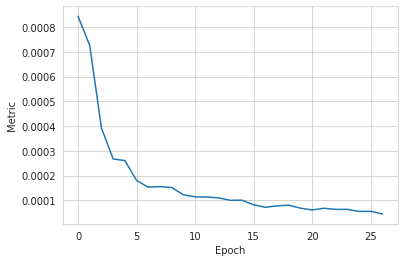

END OF EPOCH 26 / 50
model:  Distilled model  	 Size (KB): 29.4482421875
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


In [125]:
res = kdistill(
    model, student_model, student_opt, student_config, 
    (train_loader, val_loader), (melspec_train, melspec_val),
    val_hist_path='/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/kd_%d_dkd_%d_%d_hist.npy' % (att_sz, student_config.hidden_size, student_config.cnn_out_channels),
    model_path='/content/drive/MyDrive/Colab Notebooks/DLA/KWS/student_models/student_model_kd_%d_dkd_%d_%d.pt' % (att_sz, student_config.hidden_size, student_config.cnn_out_channels),
    att_sz=att_sz)

In [130]:
table_ = res[1].copy()

In [133]:
table_['SETTING'].iloc[0] = 'KD_16 + DKD_16_4'
table_

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,SETTING,MACS,MB_SZ,N_PARAMS,METRIC,batch_size,bidirectional,cnn_out_channels,device,gru_num_layers,hidden_size,attention_size,kernel_size,keyword,learning_rate,n_mels,num_classes,num_epochs,sample_rate,stride,weight_decay
0,KD_16 + DKD_16_4,150952.0,0.028758,6679.0,0.000045,128,False,4,cuda:0,2,16,16,"(5, 20)",sheila,0.0003,40,2,50,16000,"(2, 8)",0.00001


In [135]:
(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/kws_experiments.csv').append(table_)).to_csv('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/kws_experiments.csv',index=False)

## Setting 4.1 Attention Distillation + DKD + Dynamic Quantization

In [53]:
att_sz = 16
student_config = TaskConfig()
student_config.hidden_size = 16
student_config.cnn_out_channels = 4

student_model = CRNN(student_config)
student_model.attention = Attention(student_config.hidden_size, att_sz)
student_model.to(student_config.device)
student_model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(72, 16, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=16, out_features=2, bias=True)
)

In [54]:
student_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/student_models/student_model_kd_16_dkd_16_4.pt', map_location=student_config.device))

<All keys matched successfully>

In [55]:
student_model.to('cpu')
model_kd16_dkd16_4_dqint8 = torch.quantization.quantize_dynamic(
    student_model, {nn.GRU, nn.Linear}, dtype=torch.qint8
)
model_kd16_dkd16_4_dqint8

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): DynamicQuantizedGRU(72, 16, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): DynamicQuantizedLinear(in_features=16, out_features=16, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
      (1): Tanh()
      (2): DynamicQuantizedLinear(in_features=16, out_features=1, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    )
  )
  (classifier): DynamicQuantizedLinear(in_features=16, out_features=2, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)

In [56]:
cpu_config = TaskConfig()
cpu_config.device = 'cpu'
melspec_cpu = LogMelspec(False, cpu_config)
kd16_dkd16_4_dqint8_mb_sz = print_size_of_model(model_kd16_dkd16_4_dqint8, 'Knowledge Distillation + Dynamic Quantization') / (2**20)
kd16_dkd16_4_dqint8_macs, kd16_dkd16_4_dqint8_n_params = profile(model_kd16_dkd16_4_dqint8, (torch.randn(1,40,101),))
kd16_dkd16_4_dqint8_score = validation(
    model_kd16_dkd16_4_dqint8, val_loader, melspec_cpu, device='cpu'
)

model:  Knowledge Distillation + Dynamic Quantization  	 Size (KB): 15.2841796875
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and z

102it [00:11,  8.50it/s]


In [57]:
table_ = pd.DataFrame()
table_= table_.append(
    {
        **{
            'SETTING': 'KD_16 + DKD_16_4 + dqint8',
            'MACS': kd16_dkd16_4_dqint8_macs, 'MB_SZ': kd16_dkd16_4_dqint8_mb_sz, 'N_PARAMS': kd16_dkd16_4_dqint8_n_params, 
            'METRIC': kd16_dkd16_4_dqint8_score, 'attention_size': att_sz
        },
        **config_to_dict(student_config) 
    },
    ignore_index=True
)
table_
# table_.to_csv('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/kws_experiments.csv', mode='a', header=False, index=False)

,MACS,MB_SZ,METRIC,N_PARAMS,SETTING,attention_size,batch_size,bidirectional,cnn_out_channels,device,gru_num_layers,hidden_size,kernel_size,keyword,learning_rate,n_mels,num_classes,num_epochs,sample_rate,stride,weight_decay
0,79992.0,0.014926,0.000046,404.0,KD_16 + DKD_16_4 + dqint8,16.0,128.0,0.0,4.0,cuda:0,2.0,16.0,"(5, 20)",sheila,0.0003,40.0,2.0,20.0,16000.0,"(2, 8)",0.00001


In [59]:
(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/kws_experiments.csv').append(table_)).to_csv('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/kws_experiments.csv',index=False)

# Results

Графики MACS - METRIC, MB_SZ - METRIC, MACS - MB_SZ

## Overall results

Сводная таблица результатов. Здесь же правим подсчёт MACS для моделей с квантизацией.

На общих графиках мало что видно, отдельно рассмотрим результаты для разных DKD моделей.

### Training Logs

Ещё один график plotly логов всех запусков обучения. 

In [90]:
import plotly.express as px
import plotly.graph_objects as go
import glob

all_histories = {}
for hist_fname in glob.glob('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/*'):
    print(hist_fname)
    try:
        arr = np.load(hist_fname)
        all_histories[hist_fname[hist_fname.rfind('/')+1:-4]] = arr
    except:
        continue

/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/dkd_hist_16_4.npy
/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/dkd_hist_16_8.npy
/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/dkd_hist_32_4.npy
/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/dkd_hist_32_8.npy
/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/dkd_hist_8_4.npy
/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/dkd_hist_8_8.npy
/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/dkd_hist_8_16.npy
/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/dkd_hist_16_16.npy
/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/dkd_hist_32_16.npy
/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/dkd_hist_64_4.npy
/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/base_hist.npy
/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/kd_hist_16.npy
/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/kd_16_dkd_16_4_hist.npy


In [92]:
import plotly.express as px
import plotly.graph_objects as go
base_hist = all_histories['base_hist']
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(base_hist)), y=base_hist,
                    mode='lines', line=dict(color='black'),
                    name='BASE MODEL'))
for setting in all_histories.keys():
    if setting == 'base_hist': continue
    arr = all_histories[setting]
    fig.add_trace(
        go.Scatter(
            x=np.arange(len(arr)), y=arr,
            mode='lines', line=dict(dash='dash'),
            name=setting
        )
    )

fig.update_layout(title='AU_FA_FR on validation',
                   xaxis_title='epochs',
                   yaxis_title='AU_FA_FR')

fig.show()

### Сводная таблица результатов и графики

In [60]:
import pandas as pd
table = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/kws_experiments.csv',index_col=0)
table

,MACS,MB_SZ,N_PARAMS,METRIC,batch_size,bidirectional,cnn_out_channels,device,gru_num_layers,hidden_size,kernel_size,keyword,learning_rate,n_mels,num_classes,num_epochs,sample_rate,stride,weight_decay,attention_size
SETTING,,,,,,,,,,,,,,,,,,,,
Base_5e-5,1867616.0,0.273000,70443.0,0.000040,128.0,0.0,8.0,cpu,2.0,64.0,"(5, 20)",sheila,0.0003,40.0,2.0,20.0,16000.0,"(2, 8)",0.00001,NaN
dqint8,159984.0,0.078708,808.0,0.000039,128.0,0.0,8.0,cpu,2.0,64.0,"(5, 20)",sheila,0.0003,40.0,2.0,20.0,16000.0,"(2, 8)",0.00001,NaN
DKD_16_4,150952.0,0.029775,6679.0,0.000052,128.0,0.0,4.0,cpu,2.0,16.0,"(5, 20)",sheila,0.0003,40.0,2.0,20.0,16000.0,"(2, 8)",0.00001,NaN
DKD_16_4 + dqint8,79992.0,0.014926,404.0,0.000053,128.0,0.0,4.0,cpu,2.0,16.0,"(5, 20)",sheila,0.0003,40.0,2.0,20.0,16000.0,"(2, 8)",0.00001,NaN
DKD_16_8,268960.0,0.044484,10539.0,0.000054,128.0,0.0,8.0,cpu,2.0,16.0,"(5, 20)",sheila,0.0003,40.0,2.0,50.0,16000.0,"(2, 8)",0.00001,NaN
DKD_32_8,434256.0,0.101125,25387.0,0.000053,128.0,0.0,8.0,cpu,2.0,32.0,"(5, 20)",sheila,0.0003,40.0,2.0,50.0,16000.0,"(2, 8)",0.00001,NaN
DKD_32_4,278232.0,0.073232,18071.0,0.000055,128.0,0.0,4.0,cpu,2.0,32.0,"(5, 20)",sheila,0.0003,40.0,2.0,50.0,16000.0,"(2, 8)",0.00001,NaN
DKD_8_8,207432.0,0.022532,5035.0,0.000074,128.0,0.0,8.0,cuda:0,2.0,8.0,"(5, 20)",sheila,0.0003,40.0,2.0,50.0,16000.0,"(2, 8)",0.00001,NaN
DKD_8_16,405432.0,0.038768,9299.0,0.000120,128.0,0.0,16.0,cuda:0,2.0,8.0,"(5, 20)",sheila,0.0003,40.0,2.0,50.0,16000.0,"(2, 8)",0.00001,NaN


Исправим подсчёт маков для квантизованных моделей (по неквантизованным моделям).

In [61]:
table['MACS'].loc['dqint8'] = table['MACS'].loc['Base_5e-5']
table['MACS'].loc['DKD_16_4 + dqint8'] = table['MACS'].loc['DKD_16_4']
table['MACS'].loc['KD_16 + dqint8'] = table['MACS'].loc['KD_16']
table['MACS'].loc['KD_16 + DKD_16_4 + dqint8'] = table['MACS'].loc['KD_16 + DKD_16_4']
table

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,MACS,MB_SZ,N_PARAMS,METRIC,batch_size,bidirectional,cnn_out_channels,device,gru_num_layers,hidden_size,kernel_size,keyword,learning_rate,n_mels,num_classes,num_epochs,sample_rate,stride,weight_decay,attention_size
SETTING,,,,,,,,,,,,,,,,,,,,
Base_5e-5,1867616.0,0.273000,70443.0,0.000040,128.0,0.0,8.0,cpu,2.0,64.0,"(5, 20)",sheila,0.0003,40.0,2.0,20.0,16000.0,"(2, 8)",0.00001,NaN
dqint8,1867616.0,0.078708,808.0,0.000039,128.0,0.0,8.0,cpu,2.0,64.0,"(5, 20)",sheila,0.0003,40.0,2.0,20.0,16000.0,"(2, 8)",0.00001,NaN
DKD_16_4,150952.0,0.029775,6679.0,0.000052,128.0,0.0,4.0,cpu,2.0,16.0,"(5, 20)",sheila,0.0003,40.0,2.0,20.0,16000.0,"(2, 8)",0.00001,NaN
DKD_16_4 + dqint8,150952.0,0.014926,404.0,0.000053,128.0,0.0,4.0,cpu,2.0,16.0,"(5, 20)",sheila,0.0003,40.0,2.0,20.0,16000.0,"(2, 8)",0.00001,NaN
DKD_16_8,268960.0,0.044484,10539.0,0.000054,128.0,0.0,8.0,cpu,2.0,16.0,"(5, 20)",sheila,0.0003,40.0,2.0,50.0,16000.0,"(2, 8)",0.00001,NaN
DKD_32_8,434256.0,0.101125,25387.0,0.000053,128.0,0.0,8.0,cpu,2.0,32.0,"(5, 20)",sheila,0.0003,40.0,2.0,50.0,16000.0,"(2, 8)",0.00001,NaN
DKD_32_4,278232.0,0.073232,18071.0,0.000055,128.0,0.0,4.0,cpu,2.0,32.0,"(5, 20)",sheila,0.0003,40.0,2.0,50.0,16000.0,"(2, 8)",0.00001,NaN
DKD_8_8,207432.0,0.022532,5035.0,0.000074,128.0,0.0,8.0,cuda:0,2.0,8.0,"(5, 20)",sheila,0.0003,40.0,2.0,50.0,16000.0,"(2, 8)",0.00001,NaN
DKD_8_16,405432.0,0.038768,9299.0,0.000120,128.0,0.0,16.0,cuda:0,2.0,8.0,"(5, 20)",sheila,0.0003,40.0,2.0,50.0,16000.0,"(2, 8)",0.00001,NaN


In [62]:
base_scores = table.loc['Base_5e-5']

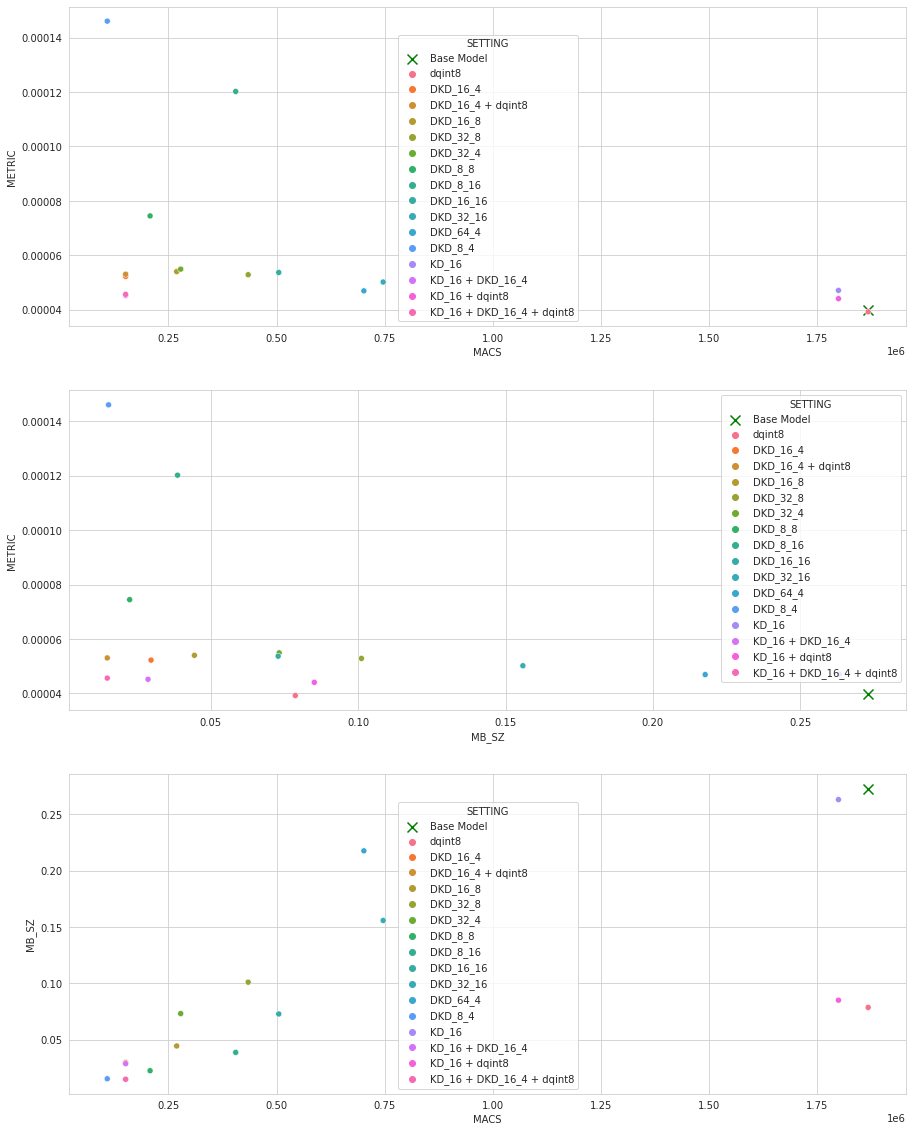

In [63]:
fig, axs = plt.subplots(3, 1, figsize=(15,20))
sns.set_palette('rocket_r')
axs[0].scatter([base_scores['MACS']],[base_scores['METRIC']], color='green', label='Base Model', s=100, marker='x')
sns.scatterplot(data=table.iloc[1:], x='MACS', y='METRIC', hue='SETTING', ax=axs[0])

axs[1].scatter([base_scores['MB_SZ']],[base_scores['METRIC']], color='green', label='Base Model', s=100, marker='x')
sns.scatterplot(data=table.iloc[1:], x='MB_SZ', y='METRIC', hue='SETTING', ax=axs[1])

axs[2].scatter([base_scores['MACS']],[base_scores['MB_SZ']], color='green', label='Base Model', s=100, marker='x')
sns.scatterplot(data=table.iloc[1:], x='MACS', y='MB_SZ', hue='SETTING', ax=axs[2])
plt.show()

## DKD Results

Выведем результаты отдельно для DKD моделей (без квантизации и Knowledge Distillation). На графиках группируем по параметрам, которые перебирали -- `hidden_size` и `cnn_out_channels`.

In [ ]:
# import numpy as np
# from itertools import product
# results = {}
# for (h,c) in product([8,16,32,64], [4,8,16]):
#     try:
#         arr = np.load('/content/drive/MyDrive/Colab Notebooks/DLA/KWS/history/dkd_hist_%d_%d.npy' % (h, c))
#         results[(h, c)] = arr
#     except:
#         continue
# See DKD Training Logs

dkd_names = ['DKD_%d_%d' % key  for key in results.keys()]
# dkd_names
dkd_df = table.loc[dkd_names]

In [ ]:
def label_point(data, x, y, ax, alpha=1):
    # function for point labelling from https://stackoverflow.com/questions/46027653/adding-labels-in-x-y-scatter-plot-with-seaborn
    for i, point in data.iterrows():
        ax.text(x=point[x], y=point[y], s=point.name, alpha=alpha)

### Группировка по `hidden_size`

Здесь мало что видно для всех `hidden_size` не равных 8 (у всех качество примерно около порога 5.5е-5). Видно, что модель с параметрами `hidden_size` = 16, `cnn_out_channels` = 4 наилучшая.

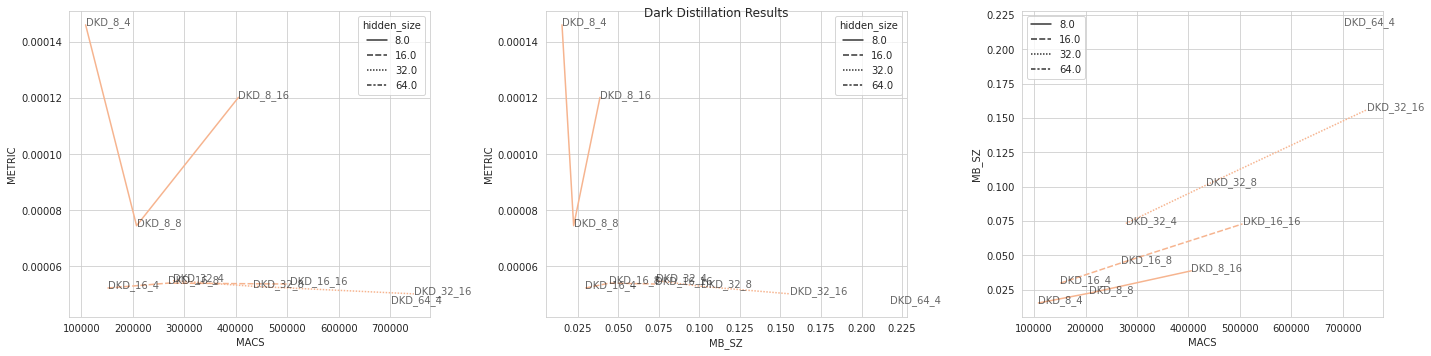

In [560]:
fig, axs = plt.subplots(1,3, figsize=(20,5))
fig.suptitle('Dark Distillation Results')

sns.lineplot(data=dkd_df, x='MACS', y='METRIC', style='hidden_size', ax=axs[0])
# axs[0].scatter([base_scores['MACS']],[base_scores['METRIC']], color='green', label='Base Model', s=100, marker='x')
label_point(dkd_df, x='MACS', y='METRIC',ax=axs[0], alpha=.7)

sns.lineplot(data=dkd_df, x='MB_SZ', y='METRIC', style='hidden_size', ax=axs[1])
# axs[1].scatter([base_scores['MB_SZ']],[base_scores['METRIC']], color='green', label='Base Model', s=100, marker='x')
label_point(dkd_df, x='MB_SZ', y='METRIC',ax=axs[1], alpha=.7)

sns.lineplot(data=dkd_df, x='MACS', y='MB_SZ', style='hidden_size', ax=axs[2])
# axs[2].scatter([base_scores['MACS']],[base_scores['MB_SZ']], color='green', label='Base Model', s=100, marker='x')
label_point(dkd_df, x='MACS', y='MB_SZ',ax=axs[2], alpha=.7)
plt.tight_layout()
plt.legend()
plt.show()

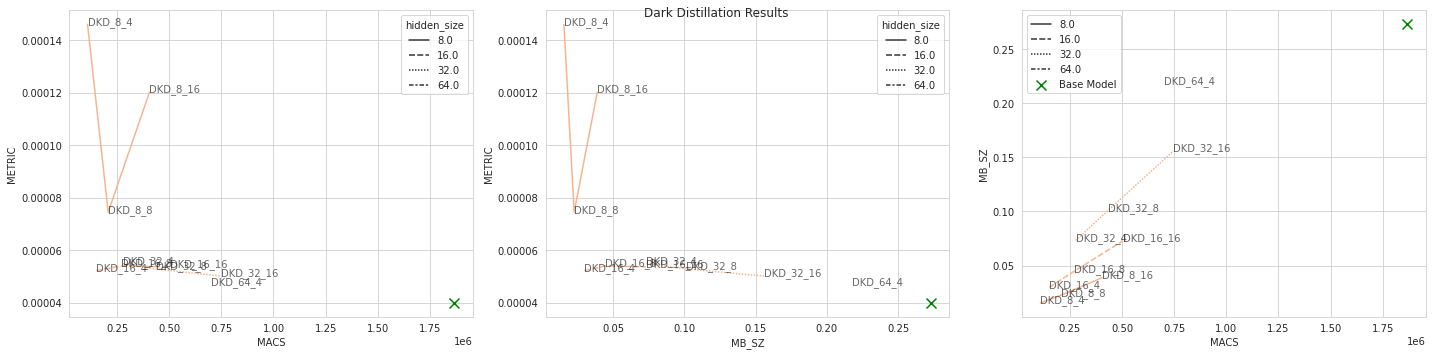

In [ ]:
# with base model results marked
fig, axs = plt.subplots(1,3, figsize=(20,5))
fig.suptitle('Dark Distillation Results')

sns.lineplot(data=dkd_df, x='MACS', y='METRIC', style='hidden_size', ax=axs[0])
axs[0].scatter([base_scores['MACS']],[base_scores['METRIC']], color='green', label='Base Model', s=100, marker='x')
label_point(dkd_df, x='MACS', y='METRIC',ax=axs[0], alpha=.7)

sns.lineplot(data=dkd_df, x='MB_SZ', y='METRIC', style='hidden_size', ax=axs[1])
axs[1].scatter([base_scores['MB_SZ']],[base_scores['METRIC']], color='green', label='Base Model', s=100, marker='x')
label_point(dkd_df, x='MB_SZ', y='METRIC',ax=axs[1], alpha=.7)

sns.lineplot(data=dkd_df, x='MACS', y='MB_SZ', style='hidden_size', ax=axs[2])
axs[2].scatter([base_scores['MACS']],[base_scores['MB_SZ']], color='green', label='Base Model', s=100, marker='x')
label_point(dkd_df, x='MACS', y='MB_SZ',ax=axs[2], alpha=.7)
plt.tight_layout()
plt.legend()
plt.show()

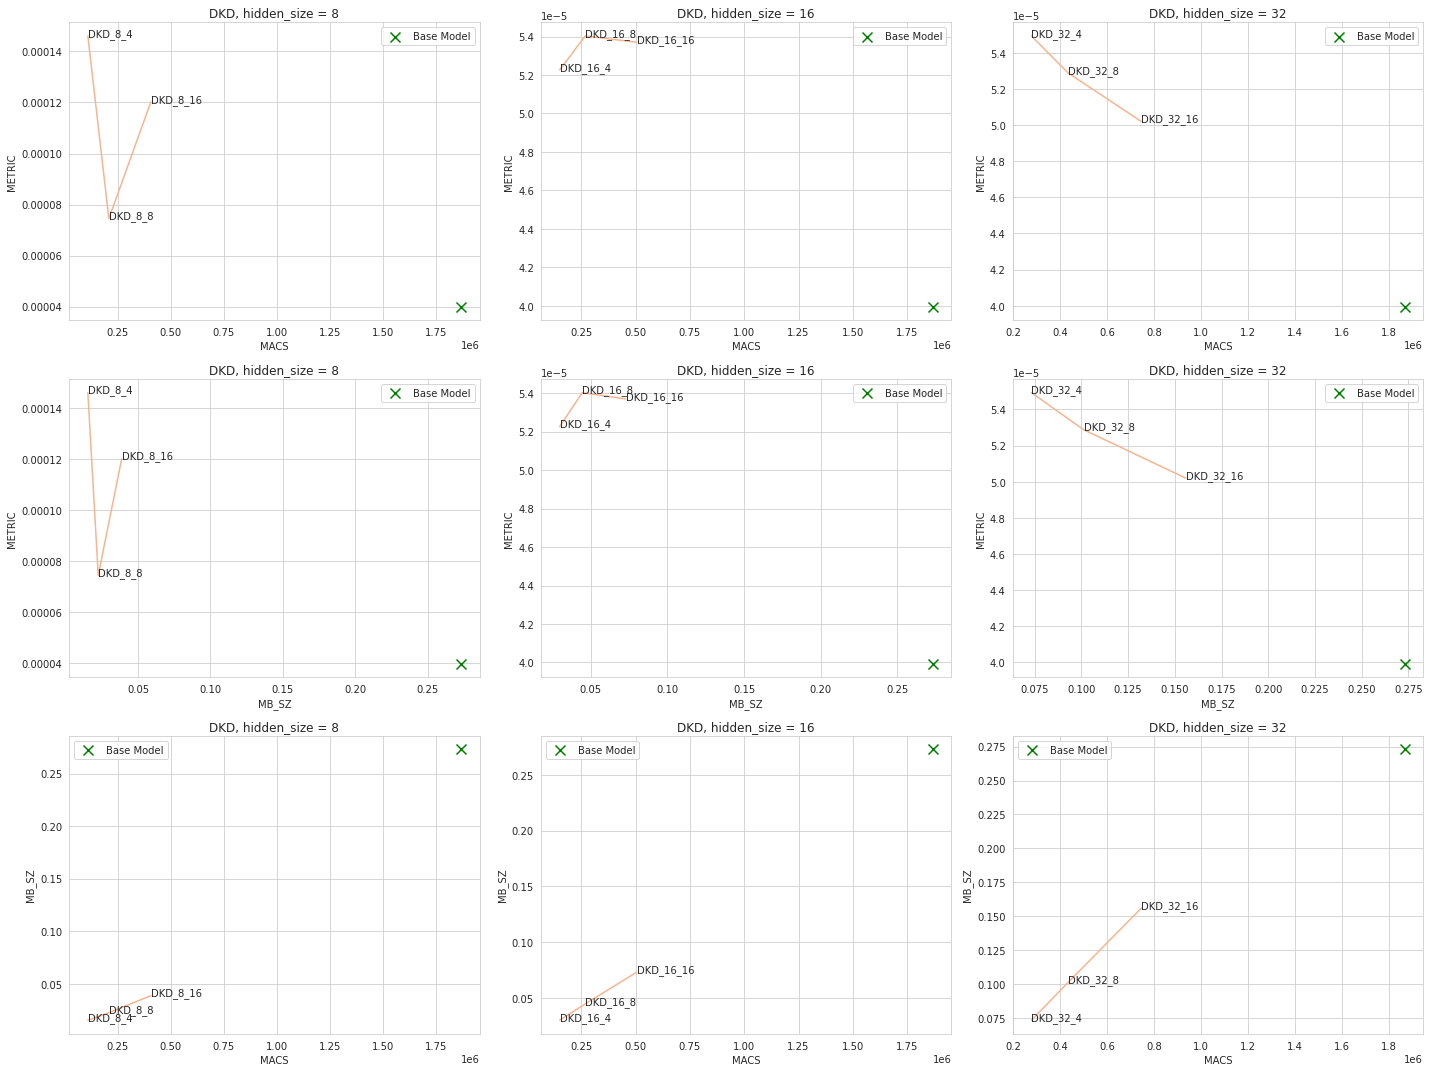

In [ ]:
# тут просто разнесём на разные подграфики, чтобы стало виднее
fig, axs = plt.subplots(3,3, figsize=(20,15))

for h, ax in zip([8, 16, 32], axs[0].reshape(-1)):
    ax.scatter([base_scores['MACS']],[base_scores['METRIC']], color='green', label='Base Model', s=100, marker='x')
    sns.lineplot(data=dkd_df[dkd_df.hidden_size == h], x='MACS', y='METRIC', ax=ax)
    label_point(dkd_df[dkd_df.hidden_size == h], x='MACS', y='METRIC', ax=ax)
    ax.set_title('DKD, hidden_size = %d' % h)
for h, ax in zip([8, 16, 32], axs[1].reshape(-1)):
    ax.scatter([base_scores['MB_SZ']],[base_scores['METRIC']], color='green', label='Base Model', s=100, marker='x')
    sns.lineplot(data=dkd_df[dkd_df.hidden_size == h], x='MB_SZ', y='METRIC', ax=ax)
    label_point(dkd_df[dkd_df.hidden_size == h], x='MB_SZ', y='METRIC', ax=ax)
    ax.set_title('DKD, hidden_size = %d' % h)
for h, ax in zip([8, 16, 32], axs[2].reshape(-1)):
    ax.scatter([base_scores['MACS']],[base_scores['MB_SZ']], color='green', label='Base Model', s=100, marker='x')
    sns.lineplot(data=dkd_df[dkd_df.hidden_size == h], x='MACS', y='MB_SZ', ax=ax)
    label_point(dkd_df[dkd_df.hidden_size == h], x='MACS', y='MB_SZ', ax=ax)
    ax.set_title('DKD, hidden_size = %d' % h)
plt.tight_layout()

### Группировка по `cnn_out_channels`

По графикам с метрикой видно, что разница между вариантами, где `hidden_size` равен 8 и 16, значительнее по сравнению со случаем, когда параметры равны 16 и 32 (при `hidden_size` = 8 модель за 50 эпох не обучилась на нужное качество).

Модель с параметрами `hidden_size` = 16, `cnn_out_channels` = 4 наилучшая.

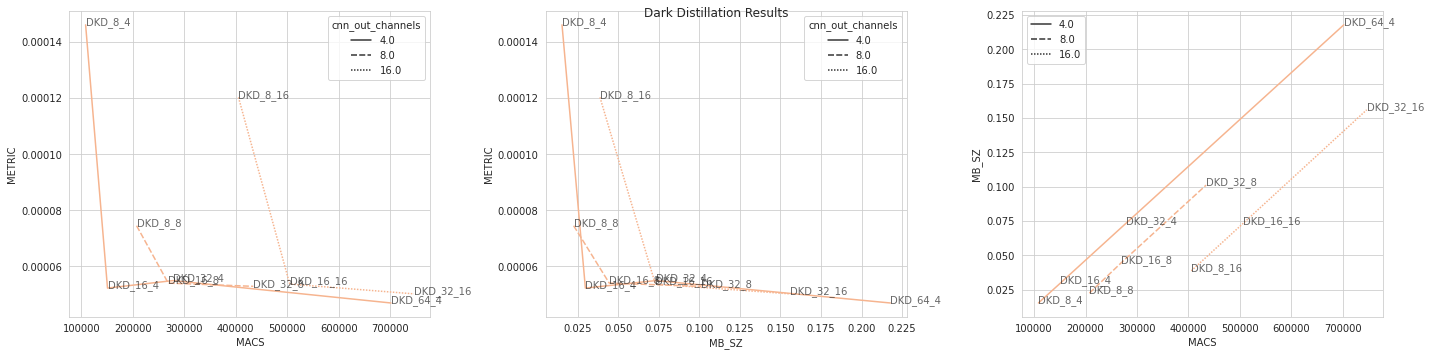

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(20,5))
fig.suptitle('Dark Distillation Results')
sns.lineplot(data=dkd_df, x='MACS', y='METRIC', style='cnn_out_channels', ax=axs[0])
label_point(dkd_df, x='MACS', y='METRIC',ax=axs[0], alpha=.7)
sns.lineplot(data=dkd_df, x='MB_SZ', y='METRIC', style='cnn_out_channels', ax=axs[1])
label_point(dkd_df, x='MB_SZ', y='METRIC',ax=axs[1], alpha=.7)
sns.lineplot(data=dkd_df, x='MACS', y='MB_SZ', style='cnn_out_channels', ax=axs[2])
label_point(dkd_df, x='MACS', y='MB_SZ',ax=axs[2], alpha=.7)
plt.tight_layout()
plt.legend()
plt.show()

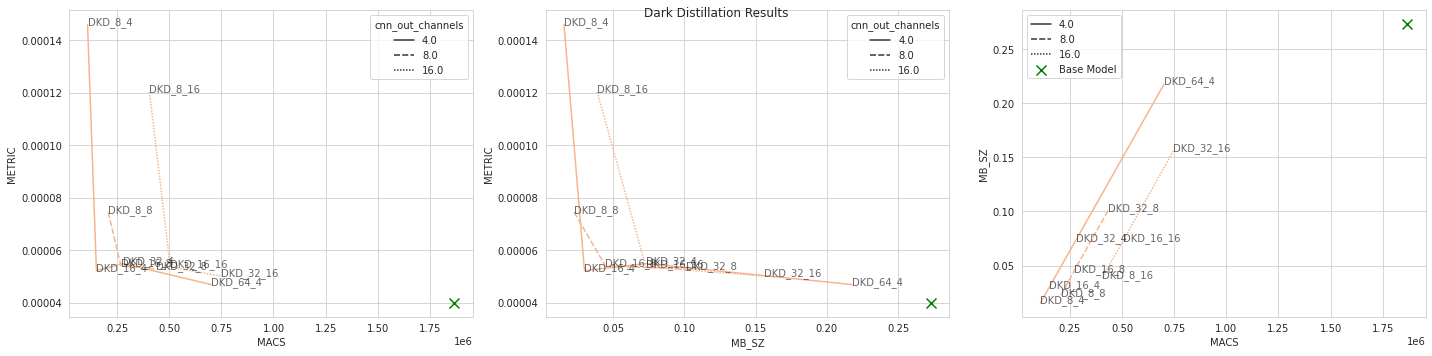

In [ ]:
# with base model results marked
fig, axs = plt.subplots(1,3, figsize=(20,5))
fig.suptitle('Dark Distillation Results')

sns.lineplot(data=dkd_df, x='MACS', y='METRIC', style='cnn_out_channels', ax=axs[0])
axs[0].scatter([base_scores['MACS']],[base_scores['METRIC']], color='green', label='Base Model', s=100, marker='x')
label_point(dkd_df, x='MACS', y='METRIC',ax=axs[0],alpha=.7)

sns.lineplot(data=dkd_df, x='MB_SZ', y='METRIC', style='cnn_out_channels', ax=axs[1])
axs[1].scatter([base_scores['MB_SZ']],[base_scores['METRIC']], color='green', label='Base Model', s=100, marker='x')
label_point(dkd_df, x='MB_SZ', y='METRIC',ax=axs[1],alpha=.7)

sns.lineplot(data=dkd_df, x='MACS', y='MB_SZ', style='cnn_out_channels', ax=axs[2])
axs[2].scatter([base_scores['MACS']],[base_scores['MB_SZ']], color='green', label='Base Model', s=100, marker='x')
label_point(dkd_df, x='MACS', y='MB_SZ',ax=axs[2],alpha=.7)
plt.tight_layout()
plt.legend()
plt.show()

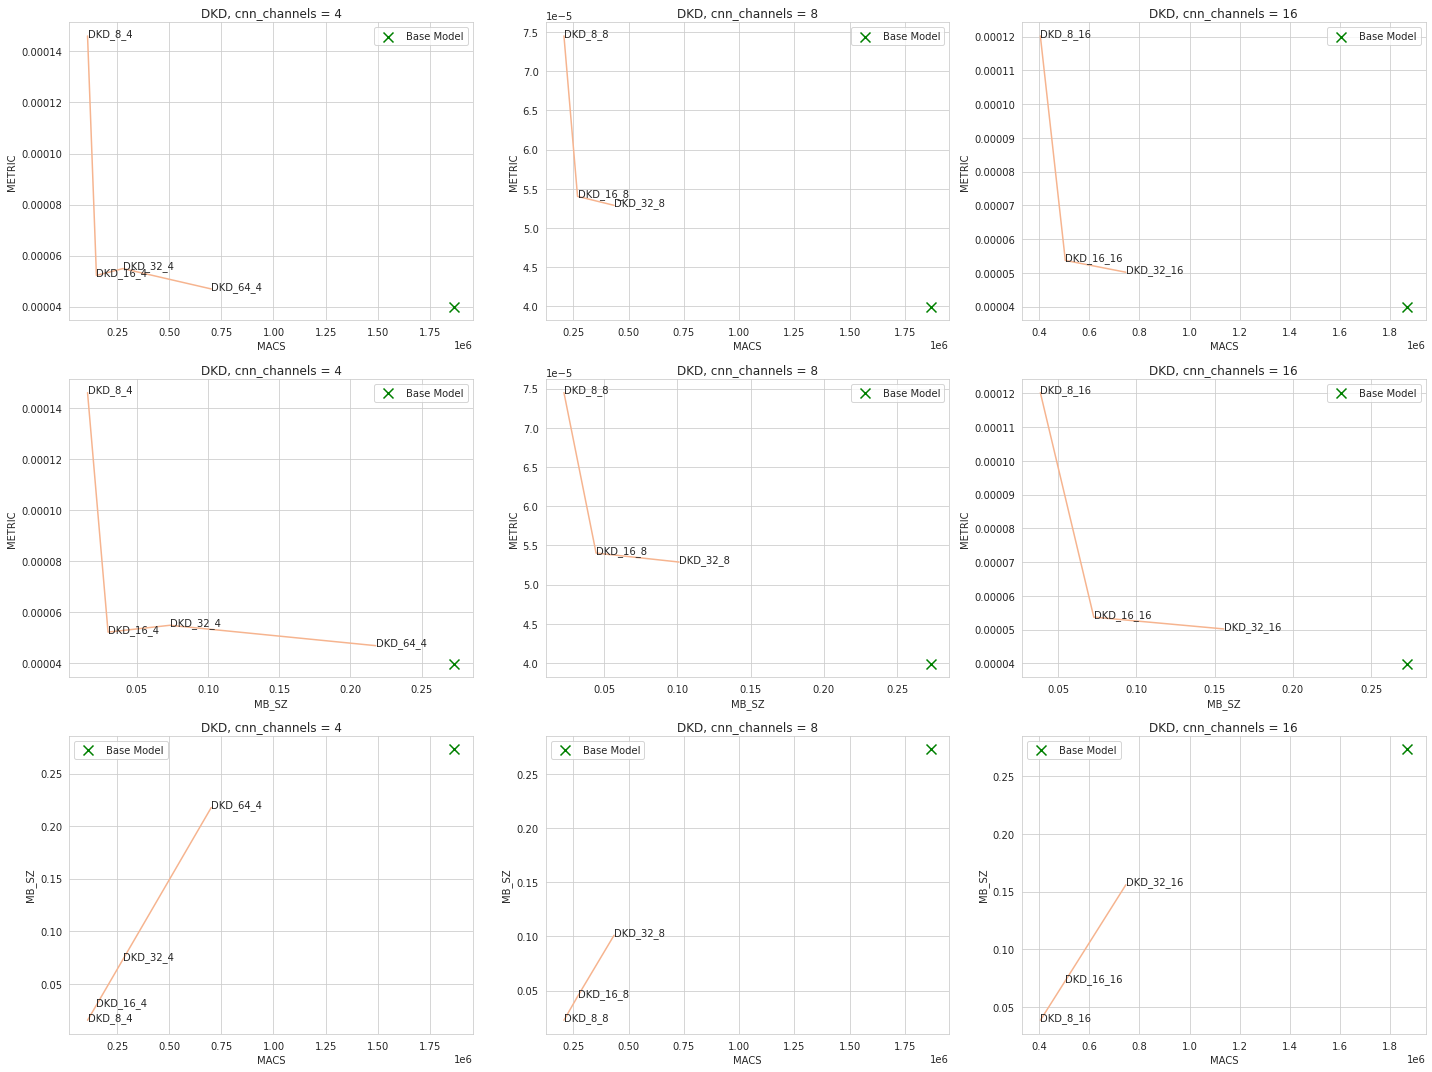

In [ ]:
# чтобы виднее было
fig, axs = plt.subplots(3,3, figsize=(20,15))

for c, ax in zip([4, 8, 16], axs[0].reshape(-1)):
    ax.scatter([base_scores['MACS']],[base_scores['METRIC']], color='green', label='Base Model', s=100, marker='x')
    sns.lineplot(data=dkd_df[dkd_df.cnn_out_channels == c], x='MACS', y='METRIC', ax=ax)
    label_point(dkd_df[dkd_df.cnn_out_channels == c], x='MACS', y='METRIC', ax=ax)
    ax.set_title('DKD, cnn_channels = %d' % c)
for c, ax in zip([4, 8, 16], axs[1].reshape(-1)):
    ax.scatter([base_scores['MB_SZ']],[base_scores['METRIC']], color='green', label='Base Model', s=100, marker='x')
    sns.lineplot(data=dkd_df[dkd_df.cnn_out_channels == c], x='MB_SZ', y='METRIC', ax=ax)
    label_point(dkd_df[dkd_df.cnn_out_channels == c], x='MB_SZ', y='METRIC', ax=ax)
    ax.set_title('DKD, cnn_channels = %d' % c)
for c, ax in zip([4, 8, 16], axs[2].reshape(-1)):
    ax.scatter([base_scores['MACS']],[base_scores['MB_SZ']], color='green', label='Base Model', s=100, marker='x')
    sns.lineplot(data=dkd_df[dkd_df.cnn_out_channels == c], x='MACS', y='MB_SZ', ax=ax)
    label_point(dkd_df[dkd_df.cnn_out_channels == c], x='MACS', y='MB_SZ', ax=ax)
    ax.set_title('DKD, cnn_channels = %d' % c)
plt.tight_layout()

## Final

По предыдщим результатам получилось, что модель с конфигурацией `DKD_16_4` (Dark Knowledge Distillation, `hidden_size` = 16, `cnn_out_channels` = 4) лучшая. Добавление динамической квантизации улучшает компрессию в памяти, а добавление дистилляции Attention модуля улучшает итоговое качество модели (итоговой конфигурацией выберем `KD_16 + DKD_16_4 + dqint8`).

In [68]:
best_scores = table.loc['KD_16 + DKD_16_4 + dqint8']    # model saved at student_models/student_model_kd_16_dkd_16_4.pt

In [69]:
print('MACS difference %f' % (base_scores.MACS / best_scores.MACS))
print('SIZE (MB) difference %f' % (base_scores.MB_SZ / best_scores.MB_SZ))

MACS difference 12.372251
SIZE (MB) difference 18.290269


In [70]:
print(base_scores.METRIC, best_scores.METRIC)

3.994079596044769e-05 4.565472276937175e-05
